In [2]:
from copy import deepcopy
from typing import Callable, Any
from random import choice

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def objective(x, y):
    return np.cos(np.sin(y)) * np.sin(x)

In [4]:
def plot_3d(f: Callable[[float, float], np.float64]):
    x_iter = np.linspace(-5, 5, 100)
    y_iter = np.linspace(-5, 5, 100)

    x, y = np.meshgrid(x_iter, y_iter)
    z = f(x, y)

    figure = plt.figure(figsize=(20, 18))

    ax = figure.add_subplot(1, 3, 1, projection='3d')
    ax.contour3D(x, y, z, 50)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax = figure.add_subplot(1, 3, 2, projection='3d')
    ax.contour3D(x, y, z, 50)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(90, 0)

    ax = figure.add_subplot(1, 3, 3, projection='3d')
    ax.contour3D(x, y, z, 50)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(50, 0)

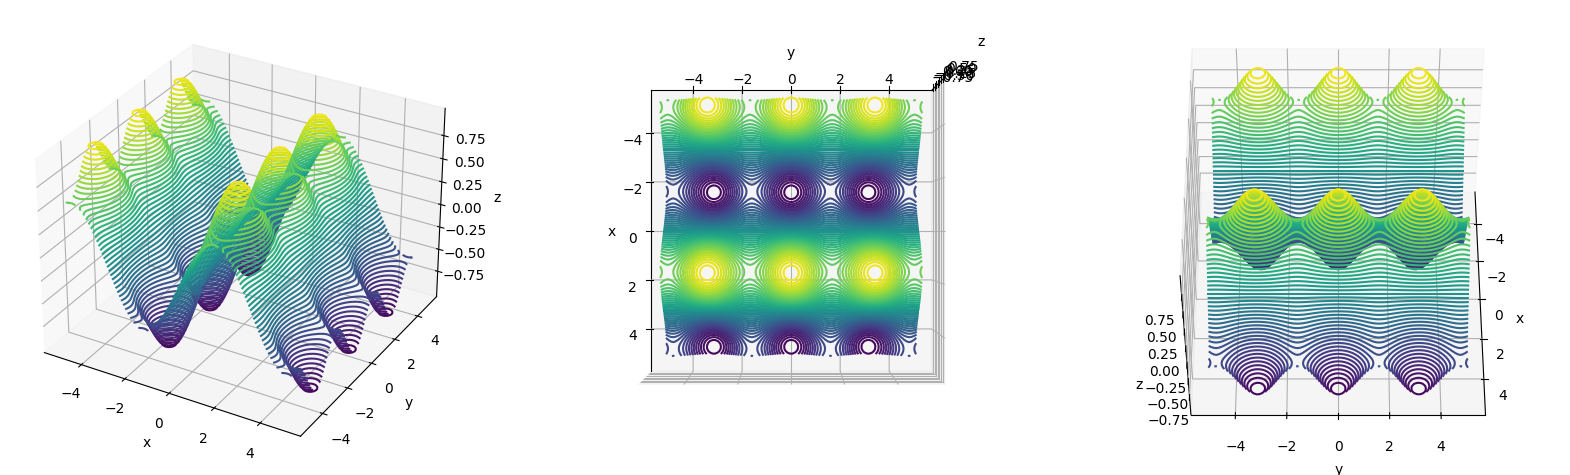

In [5]:
plot_3d(objective)

In [6]:
class NeuronNetwork:
    def __init__(self, layers: list[int]) -> None:
        self._layers = layers
        self.biases = [np.random.randn(a, 1) for a in layers[1:]]
        self.weights = [np.random.randn(a, b) for b, a in zip(layers[:-1], layers[1:])]
        self.size = len(layers)

    def feedforward(self, sig):
        for bias, weight in zip(self.biases, self.weights):
            sig = self.sigmoid(np.dot(weight, sig) + bias)

        return sig

    def evaluate(self, x_test: Any, y_test: Any) -> Any:
        score = 0

        for i in range(x_test.shape[0]):
            pred = self.feedforward(x_test[i].reshape(-1, 1))
            actual = y_test[i].reshape(-1, 1)
            score += sum((pred-actual)**2) / y_test.size

        return score

    def get_random_bias_idx(self) -> tuple[int, int]:
        layer_idx = np.random.randint(0, self.size - 2)
        bias_idx = np.random.randint(0, self.biases[layer_idx].size - 1)

        return layer_idx, bias_idx

    def get_random_weight_idx(self) -> tuple[int, tuple[int, int]]:
        layer_idx = np.random.randint(0, self.size - 2)
        x = np.random.randint(0, self.weights[layer_idx].shape[0])
        y = np.random.randint(0, self.weights[layer_idx].shape[1])

        return layer_idx, (x, y)

    @property
    def biases_count(self):
        return sum(self._layers[1:])

    @property
    def weights_count(self):
        return sum([weight.size for weight in self.weights])

    @staticmethod
    def sigmoid(x) -> float:
        return 1 / (1 + np.exp(-x))

    def __repr__(self):
        return f'Network sizeof {self.size}'

In [7]:
def crossover(parent1: NeuronNetwork, parent2: NeuronNetwork) -> NeuronNetwork:
    new_network_ = deepcopy(parent1)

    for _ in range(parent1.weights_count):
        if np.random.rand() < CROSSOVER_RATE:
            layer_idx, coors = parent1.get_random_weight_idx()
            new_network_.weights[layer_idx][coors] = parent2.weights[layer_idx][coors]

    for _ in range(parent1.biases_count):
        if np.random.rand() < CROSSOVER_RATE:
            layer_idx, coors = parent1.get_random_bias_idx()
            new_network_.biases[layer_idx][coors] = parent2.biases[layer_idx][coors]

    return new_network_

In [8]:
def mutate(network: NeuronNetwork) -> NeuronNetwork:
    network_copy = deepcopy(network)

    for _ in range(network_copy.biases_count):
        if np.random.rand() < MUTATION_RATE:
            layer_idx, coors = network_copy.get_random_bias_idx()
            network_copy.biases[layer_idx][coors] += np.random.uniform(-0.5, 0.5)

    for _ in range(network_copy.weights_count):
        if np.random.rand() < MUTATION_RATE:
            layer_idx, coors = network_copy.get_random_weight_idx()
            network_copy.weights[layer_idx][coors] += np.random.uniform(-0.5, 0.5)

    return network_copy

In [9]:
def calculate_metrics(networks_: list[NeuronNetwork], points_, z_) -> float:
    evaluations = [net.evaluate(points_, z_) for net in networks_]
    return np.average(evaluations)

# MAIN

In [10]:
CROSSOVER_RATE = 0.4
MUTATION_RATE = 0.3
POPULATION = 25
LAYERS = [2, 4, 8, 10, 6, 6, 1]
RETAIN_RATE = 0.4
EPOCHS = 100

In [14]:
points = np.random.uniform(0, 1, (1000, 2))
z = [objective(*point) for point in points]

In [15]:
networks = [
    NeuronNetwork(LAYERS) for _ in range(POPULATION)
]

In [16]:
for epoch in range(EPOCHS):
    # choose the best networks we have
    networks_scores = sorted(list(zip(networks, [net.evaluate(points, z) for net in networks])), key=lambda pair: pair[1][0])
    retain_idx = int(np.floor(POPULATION * RETAIN_RATE))
    best_networks = [pair[0] for pair in networks_scores[:retain_idx]]

    # adding some random networks
    random_networks_count = np.random.randint(0, (POPULATION - retain_idx)*RETAIN_RATE)
    for _ in range(random_networks_count):
        random_net_score_pair = choice(networks_scores[retain_idx:])
        best_networks.append(random_net_score_pair[0])

    while len(best_networks) < POPULATION:
        parent_1, parent_2 = choice(best_networks), choice(best_networks)

        if parent_1 == parent_2:
            continue

        new_network = crossover(parent_1, parent_2)
        new_network = mutate(new_network)
        best_networks.append(new_network)

    networks = best_networks

    print(f"EPOCH: {epoch} with average score: {calculate_metrics(networks, points, z)}")

EPOCH: 0 with average score: 43.383173821989956
EPOCH: 1 with average score: 44.229730850702715
EPOCH: 2 with average score: 32.33086284548018
EPOCH: 3 with average score: 29.3899288517218
EPOCH: 4 with average score: 27.964483949201977
EPOCH: 5 with average score: 28.98684325319205
EPOCH: 6 with average score: 30.422800333444165
EPOCH: 7 with average score: 31.965747446048155
EPOCH: 8 with average score: 28.517925434295407
EPOCH: 9 with average score: 28.555691023150032
EPOCH: 10 with average score: 30.793225688964853
EPOCH: 11 with average score: 30.927346755783823
EPOCH: 12 with average score: 30.711699652531635
EPOCH: 13 with average score: 28.40484054913799
EPOCH: 14 with average score: 29.37183426311401
EPOCH: 15 with average score: 30.139318837610972
EPOCH: 16 with average score: 27.964102944587527
EPOCH: 17 with average score: 27.552707735479203
EPOCH: 18 with average score: 28.154278360824033
EPOCH: 19 with average score: 28.17553026029839
EPOCH: 20 with average score: 28.7398